# Library

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T
from copy import deepcopy
from scipy import stats
from pprint import pprint
from collections import Counter
from tqdm import tqdm
%matplotlib inline
print('Loaded 1')


exec(open('utils.py').read())
print('Loaded 2')

Loaded 1
Loaded 2


In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 100*K                                      # Number of runs to do (default 100*K)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)


years = range(CURRENT_YEAR, MAX_YEAR)
print('Loaded')


Loaded


# Model

### TAI Scenarios

In [3]:
# Conditoinal on making TAI, will it be agentic?
p_make_agent_tai = 0.9

# Conditional on making agentic TAI, will it be aligned by default?
p_tai_aligned_by_default = 0.2

# Conditional on making agentic TAI that is not aligned by default, will we solve the alignment problem?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_solved(war, year, first_attempt=True, verbose=False):
    if first_attempt:
        p = min(0.1 + 1.3 * (year/45), 0.75)
    else:
        p = min(0.1 + 1.9 * (year/45), 0.85)
    if war:
        p = p * 0.7
    if verbose == 2:
        print('* alignment diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
# TODO: Convert to logistic curves

# Conditional on solving the alignment problem, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved = 0.85

# Conditional on alignment by default, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved_if_aligned_by_default = 0.4

# Conditional on having agentic TAI, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 if war else 0.05

# If TAI is fully misaligned what is the chance we can successfully detect and avert this?
p_full_tai_misalignment_averted = 0.15

# If TAI is fully misaligned but successfully averted, what is the probability there will be a catasrophe (10%+ death)?
p_tai_misalignment_averting_is_catastrophic = 0.4

# If TAI is fully misaligned and we successfully avert it, what is the chance we give up on TAI?
p_full_tai_misalignment_averted_means_abandoned_tai = 0.7

# If TAI is fully misaligned, what is the chance it results in extinction versus a singleton?
p_tai_xrisk_is_extinction = 0.4

# If there is a fully misaligned TAI singleton, what is the chance it results in a non-extinction catastrophe (10%+ death)?
p_tai_singleton_is_catastrophic = 0.8


exec(open('modules/tai_risk.py').read())
print('Loaded TAI scenarios module')


Loaded TAI scenarios module


### Nuclear Scenarios Module

In [4]:
def p_russia_uses_nuke(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2023:
        return 0.03
    else:
        return 0.001 / peace

    
p_nk_uses_nuke = 0.001


def p_china_invades_taiwan(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022:
        return 0
    elif year == 2023:
        return 0.01
    elif year == 2024 or year == 2025:
        return 0.047   # makes cumulative probability by EOY 2025 = 0.1
                        # solve 0.01 + (1-0.01)*X + (1-0.01)(1-X)*X = 0.1, 0>X<1
    elif year < 2030:
        return 0.078 # makes cumulative probability by EOY 2029 = 0.4
                     # solve 0.1 + (1-0.1)*X + (1-0.1)(1-X)*X + (1-0.1)(1-X)^2*X + (1-0.1)(1-X)^3*X + (1-0.1)(1-X)^4*X = 0.4
    elif year < 2035:
        return 0.097 # makes cumulative probability by EOY 2034 = 0.6
                     # 0.4 + (1-0.5)*X + (1-0.5)(1-X)*X + (1-0.5)(1-X)^2*X + (1-0.5)(1-X)^3*X + (1-0.5)(1-X)^4*X = 0.6
    else:
        return 0.005 / peace


def p_china_uses_nuke(peace, year):
    return p_china_invades_taiwan(peace, year) * 0.01

    
def p_other_uses_nuke(peace):
    peace = 10 if peace else 1
    return 0.0002 / peace


# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.05 if war else 0.02
    p = p * (0.998 ** year)
    return p


# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.2 if war else 0.05


# Conditional on a nuclear exchange, what is the chance it escalates into a catastrophe (10%+ dead)?
def p_catastrophe_from_nuclear_exchange(war):
    p_exchange_becomes_all_out_war = 0.6 if war else 0.3
    p_nuclear_winter_happens = 0.3
    alternative_foods_or_other_save = 0.05
    return (p_exchange_becomes_all_out_war *
            (p_nuclear_winter_happens + (1 - p_nuclear_winter_happens) * 0.1) *
            (1 - alternative_foods_or_other_save))
    
    
# Conditional on a nuclear exchange catastrophe, what is the chance it becomes an xrisk?
p_xrisk_from_nuclear_catastrophe = 0.05 # https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would


# Conditional on a great power war, what is the chance it goes intentionally nuclear in any given year?
def p_nuclear_exchange_given_war(first_year_of_war):
    return 0.1 if first_year_of_war else 0.02


exec(open('modules/nuclear.py').read())
print('Loaded nuclear scenarios module')


Loaded nuclear scenarios module


### Great Power War Scenarios Module

In [5]:
def p_great_power_war_us_russia_without_nuke_first(peace, year):
    peace = 20 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022 or year == 2023:
        return (0.02 / 2) / peace
    else:
        return 0.003 / peace

    
def p_great_power_war_us_china(peace, year):
    peace = 20 if peace else 1
    p_invade_taiwan = p_china_invades_taiwan(peace, year)
    p_us_responds = 0.6
    return p_invade_taiwan * p_us_responds

    
def p_great_power_war_other(peace, year):
    peace = 5 if peace else 1
    year = year + CURRENT_YEAR
    if year > 2040:
        return 0.005 / peace
    else:
        return 0.001 / peace


# Conditional on a great power war starting, how long will it last?
war_length = sq.lognorm(2, 50) # 90% CI

# After a war ends, how long will there be a peace?
peace_length = sq.lognorm(10, 100)


exec(open('modules/great_power_war.py').read())
print('Loaded great power war scenarios module')


Loaded great power war scenarios module


### Bio scenarios module

In [6]:
# Conditional on a great power war, what is the annual chance it intentionally results in a bioweapon?
p_biowar_given_war = 1/800

# What is the annual chance of a non-state actor creating an intentional biorisk that causes 1%+ death?
p_nonstate_bio = 1/1200

# What is the chance that if 1%+ die from natural bio, 10%+ will die from natural bio?
p_natural_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# What is the chance that if 1%+ die from engineered bio, 10%+ will die from engineered bio?
p_engineered_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

p_covid_spanish_flu_like_becomes_1pct_death = 1 / (10 ** 0.5) # https://www.economist.com/graphic-detail/coronavirus-excess-deaths-estimates suggests COVID killed 0.2%... https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028 suggests 1% is 2x less likely than 0.2%
p_covid_lab_leak = 0.3
p_extinction_given_90_pct_death = 0.03 # per Luisa https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would
p_accidental_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028
p_intentional_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# If a lab leak occurs, how likely is it that the leaked pandemic will be engineered vs. natural?
ratio_engineered_vs_natural_lab_leak = 0.8

# What is the chance of an natural biorisk/pandemic causing 1%+ population death?
def p_natural_bio(year):
    base_rate_from_covid_and_spanish_flu = 1/250
    increase_from_globalization = 1.1
    decreate_in_rate_per_year_from_improvements = 0.99 ** year
    return ((base_rate_from_covid_and_spanish_flu * 0.5 +
             base_rate_from_covid_and_spanish_flu * (1 - p_covid_lab_leak) * 0.5) *
            increase_from_globalization *
            p_covid_spanish_flu_like_becomes_1pct_death *
            decreate_in_rate_per_year_from_improvements)
    
    
# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_accidental_bio(war):
    base_rate_from_covid = 0.01 * p_covid_lab_leak
    increase_factor_due_to_increasing_labs = 1.3
    increase_factor_due_to_great_power_war = 2
    p = (base_rate_from_covid *
         p_covid_spanish_flu_like_becomes_1pct_death *
         increase_factor_due_to_increasing_labs)
    return p * increase_factor_due_to_great_power_war if war else p
    

# Conditional on a accidental biorisk (1% death), what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio_given_catastrophe(year):
    return p_accidental_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_engineered_bio_given_catastrophe(year):
    return p_intentional_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


exec(open('modules/bio.py').read())
print('Loaded bio scenarios module')


Loaded bio scenarios module


### Nanotech scenarios module

In [7]:
# What is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    return 0.0001 / (0.956 ** year) # TODO: This goes over 1


# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
p_nanotech_is_xrisk = 0.1 * 0.05


exec(open('modules/nano.py').read())
print('Loaded nano scenarios module')


Loaded nano scenarios module


### Supervolcano scenarios module (all other natural risks <0.01%)

In [8]:
p_supervolcano_catastrophe = 1 / (500*K)  # https://www.openphilanthropy.org/research/large-volcanic-eruptions/ VEI >= 9 (geometric mean of 30K and 30M)

p_supervolcano_extinction_given_catastrophe = 0.05


exec(open('modules/supervolcano.py').read())
print('Loaded supervolcano module')


Loaded supervolcano module


### Unknown unknown scenarios module

In [9]:
# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return (1 / (100*K)) / (0.99 ** year) # TODO: This goes over 1


p_extinction_from_double_catastrophe = 0.1
extinction_from_double_catastrophe_range = 10
    
    
exec(open('modules/unknown_unknown.py').read())
print('Loaded unknown unknown scenarios module')


Loaded unknown unknown scenarios module


### AI Timeline variables

In [10]:
exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')

print('-')
tai_years = bayes.bayesnet(load_cache_file='caches/tai_years', verbose=True)

# TODO: War spending
# TODO: TAI China delay
# TODO: TAI Catastrophe delay

print('-')
print('Loaded')


Loaded TAI timelines module
-
Loading from cache file (`caches/tai_years.sqcache`)...
...Loaded
Caching in-memory...
...Cached!
...Reducing
...Reduced!
...All done!
-
Loaded


## Model output

In [11]:
exec(open('modules/define_event.py').read())
print('Model loaded')


Model loaded


In [12]:
for i in range(20):
    print('############')
    print('## RUN {} ##'.format(i + 1))
    print('############')
    define_event(verbosity=2)

############
## RUN 1 ##
############
2079: ...catastrophe from lab-leak engineered pathogen
2090: WAR!!! (Other)
2094: War ends :)
--- /!\ TAI CREATED in 2100
2101: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
...Total loop complete in 120.25ms
-
-
############
## RUN 2 ##
############
2023: WAR!!! (US vs. China)
2028: War ends :)
--- /!\ TAI CREATED in 2044
2045: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
...Total loop complete in 163.47ms
-
-
############
## RUN 3 ##
############
2026: WAR!!! (US vs. China)
2038: War ends :)
...Total loop complete in 164.18ms
...Boring future
-
-
############
## RUN 4 ##
############
2027: WAR!!! (US vs. China)
2037: War ends :)
2083: WAR!!! (US vs. Russia)
2094: War ends :)
2103: WAR!!! (Other)
2106: War ends :)
...Total loop complete in 166.16ms
...Boring future
-
-
############
## RUN 5 ##
############
2026: WAR!!! (US vs. China)
2031: War ends :)
2079: ...XRISK from unknown unknown
..

In [13]:
%%time
collectors = bayes.bayesnet(define_event,
                            find=lambda e: e['collectors'],
                            load_cache_file='caches/future_assessment_model_cache',
                            dump_cache_file='caches/future_assessment_model_cache',
                            reload_cache=True, # False
                            raw=True,
                            verbose=True,
                            cores=5,
                            n=RUNS)

Reloading cache...
Generating Bayes net with 5 cores...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [5:56:50<00:00,  4.67it/s]


Shuffling data...
Waiting for other cores...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:46<00:00, 21.27s/it]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/future_assessment_model_cache.sqcache`...
...Cached!
...Finding
...Found!
...All done!
CPU times: user 1h 18min 43s, sys: 1min 15s, total: 1h 19min 58s
Wall time: 5h 59min 8s


## Core Analysis

4E. When TAI?
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2028',
 '10%: 2031',
 '15%: 2033',
 '20%: 2036',
 '25%: 2038',
 '35%: 2044',
 '50%: 2055',
 '60%: 2072',
 '75%: >2123',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 5 years from now',
 '10%: 8 years from now',
 '15%: 10 years from now',
 '20%: 13 years from now',
 '25%: 15 years from now',
 '35%: 21 years from now',
 '50%: 32 years from now',
 '60%: 49 years from now',
 '75%: >100 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.3%
2024-2027: 1.5%
2028-2029: 6.1%
2030-2034: 9.5%
2035-2039: 9.7%
2040-2049: 16.4%
2050-2059: 10.4%
2060-2069: 5.4%
2070-2079: 2.5%
2080-2089: 1.1%
2090-2099: 0.9%
2100-2109: 0.9%
2110-2119: 0.5%
>2120: 34.8%
-
## TAI ARRIVAL DATE BY YEAR - COMPARE TO BENCHMARK ##
By EOY 2024: 0.6%
By EOY 2025: 1.0%
By EOY 2027: 3.3% (within 5 yrs)
By EOY 2030

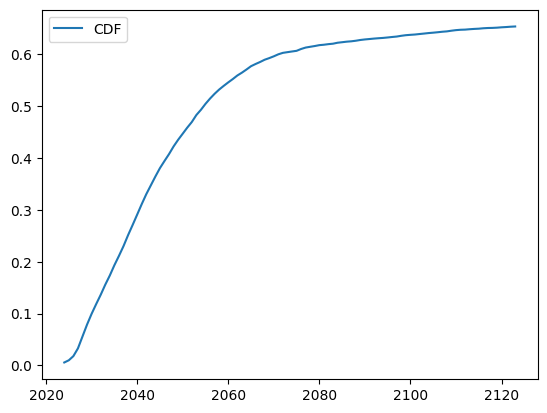

<string>:111: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:112: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

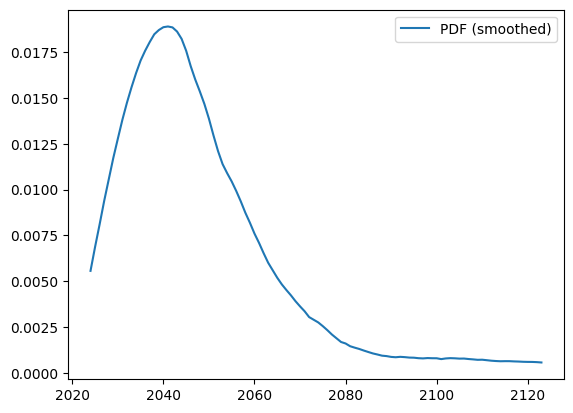

In [40]:
print('4E. When TAI?')
print('-')

yrs = bayes.bayesnet(define_event,
                     find=lambda e: e['final_state']['tai_year'],
                     raw=True,
                     n=RUNS)
yrs = [MAX_YEAR + 1 if y is None else y for y in yrs]
print_tai_arrival_stats(yrs)

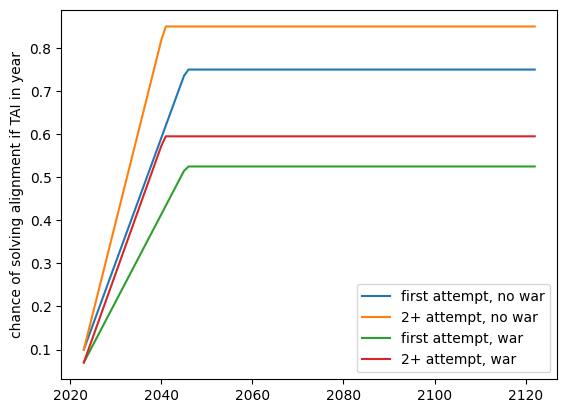

In [ ]:
alignment_p = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2 = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
alignment_pwar = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2war = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
plt.plot(years, alignment_p, label='first attempt, no war')
plt.plot(years, alignment_p2, label='2+ attempt, no war')
plt.plot(years, alignment_pwar, label='first attempt, war')
plt.plot(years, alignment_p2war, label='2+ attempt, war')
plt.legend()
plt.ylabel('chance of solving alignment if TAI in year')
plt.show()


In [ ]:
for y in list(years[:17]) + list(years[17::10]):
    str_ = 'Year: {} - chance of solving TAI alignment with war {}% (2nd attempt {}%) -- or no war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_pwar[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2war[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2[y - CURRENT_YEAR] * 100, 0)))

Year: 2023 - chance of solving TAI alignment with war 7.0% (2nd attempt 7.0%) -- or no war 10.0% (2nd attempt 10.0%)
Year: 2024 - chance of solving TAI alignment with war 9.0% (2nd attempt 10.0%) -- or no war 13.0% (2nd attempt 14.0%)
Year: 2025 - chance of solving TAI alignment with war 11.0% (2nd attempt 13.0%) -- or no war 16.0% (2nd attempt 18.0%)
Year: 2026 - chance of solving TAI alignment with war 13.0% (2nd attempt 16.0%) -- or no war 19.0% (2nd attempt 23.0%)
Year: 2027 - chance of solving TAI alignment with war 15.0% (2nd attempt 19.0%) -- or no war 22.0% (2nd attempt 27.0%)
Year: 2028 - chance of solving TAI alignment with war 17.0% (2nd attempt 22.0%) -- or no war 24.0% (2nd attempt 31.0%)
Year: 2029 - chance of solving TAI alignment with war 19.0% (2nd attempt 25.0%) -- or no war 27.0% (2nd attempt 35.0%)
Year: 2030 - chance of solving TAI alignment with war 21.0% (2nd attempt 28.0%) -- or no war 30.0% (2nd attempt 40.0%)
Year: 2031 - chance of solving TAI alignment with w

In [ ]:
print('AI X-Risk BY EOY year')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2024, 2030, 2050, 2070, 2100]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


AI X-Risk BY EOY year
2024 - 0.2% (Extinction: 0.1%, Bad TAI singleton: 0.1%, Subtly misaligned singleton: 0.1%, Misuse singleton: 0.0%)
2030 - 4.2% (Extinction: 1.3%, Bad TAI singleton: 1.7%, Subtly misaligned singleton: 0.8%, Misuse singleton: 0.4%)
2050 - 15.7% (Extinction: 3.8%, Bad TAI singleton: 5.4%, Subtly misaligned singleton: 4.8%, Misuse singleton: 1.7%)
2070 - 19.5% (Extinction: 4.4%, Bad TAI singleton: 6.4%, Subtly misaligned singleton: 6.7%, Misuse singleton: 2.0%)
2100 - 20.6% (Extinction: 4.6%, Bad TAI singleton: 6.6%, Subtly misaligned singleton: 7.2%, Misuse singleton: 2.1%)


In [ ]:
print('Chance of successfully aligning TAI by EOY year')
for y_c in [2024, 2030, 2050, 2070, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

Chance of successfully aligning TAI by EOY year
2024 - 0.04%
2030 - 2.39%
2050 - 21.94%
2070 - 32.0%
2100 - 34.89%


In [41]:
print('Cumulative Total X-Risk (including non-extinction x-risks and "good but not great" x-risks)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

for y_c in [2023, 2024, 2030, 2031, 2035, 2040, 2045, 2050, 2060, 2070, 2100]:
    ai = find(y_c, 'tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai + nukes + bio + nano + unknown) * 100, 2),
                     round(ai * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))


Cumulative Total X-Risk (including non-extinction x-risks and "good but not great" x-risks)
2023 - 0.0% (AI: 0.0%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2024 - 0.26% (AI: 0.25%, Nukes: 0.005%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2030 - 4.31% (AI: 4.24%, Nukes: 0.065%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2031 - 5.26% (AI: 5.18%, Nukes: 0.075%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2035 - 8.56% (AI: 8.44%, Nukes: 0.11%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.005%)
2040 - 11.68% (AI: 11.54%, Nukes: 0.14%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.01%)
2045 - 14.1% (AI: 13.9%, Nukes: 0.16%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.03%)
2050 - 15.89% (AI: 15.66%, Nukes: 0.195%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.03%)
2060 - 18.55% (AI: 18.29%, Nukes: 0.22%, Bio: 0.005%, Nano: 0.0%, Natural: 0.0%, Other: 0.035%)
2070 - 19.81% (AI: 19.51%, Nukes: 0.255%, Bio: 0.005%, Nano: 0.0%, Natural: 0.0%, 

In [ ]:
print('Cumulative Total Extinction Risk')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100]:
    ai = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    nukes_war = find(y_c, 'xrisk_nukes_war')
    nukes_accident = find(y_c, 'xrisk_nukes_accident')
    unknown = find(y_c, 'xrisk_unknown_unknown')
    bio_war = find(y_c, 'xrisk_bio_war')
    bio_accident = find(y_c, 'xrisk_bio_accident')
    bio_nonstate = find(y_c, 'xrisk_bio_nonstate')
    nanotech = find(y_c, 'xrisk_nanotech')
    supervolcano = find(y_c, 'xrisk_supervolcano')
    
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] in extinctions,
                       n=RUNS)
    
    out = '{} - {}% (AI: {}%, Nukes: {}% (War: {}% Accident: {}%), Bio: {}% (War: {}%, Accident: {}%, Nonstate: {}%), Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round(r * 100, 2),
                     round(ai * 100, 2),
                     round((nukes_war + nukes_accident) * 100, 3),
                     round(nukes_war * 100, 3),
                     round(nukes_accident * 100, 3),
                     round((bio_war + bio_accident + bio_nonstate) * 100, 3),
                     round(bio_war * 100, 3),
                     round(bio_accident * 100, 3),
                     round(bio_nonstate * 100, 3),
                     round(nanotech * 100, 3),
                     round(supervolcano * 100, 3),
                     round(unknown * 100, 3)))
        

Cumulative Total Extinction Risk
2030 - 1.34% (AI: 1.27%, Nukes: 0.065% (War: 0.045% Accident: 0.02%), Bio: 0.0% (War: 0.0%, Accident: 0.0%, Nonstate: 0.0%), Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2050 - 3.98% (AI: 3.76%, Nukes: 0.195% (War: 0.12% Accident: 0.075%), Bio: 0.0% (War: 0.0%, Accident: 0.0%, Nonstate: 0.0%), Nano: 0.0%, Natural: 0.0%, Other: 0.03%)
2100 - 5.07% (AI: 4.61%, Nukes: 0.345% (War: 0.225% Accident: 0.12%), Bio: 0.02% (War: 0.0%, Accident: 0.015%, Nonstate: 0.005%), Nano: 0.015%, Natural: 0.0%, Other: 0.085%)


In [43]:
print('Cumulative Total *Actively Bad* Future X-Risk (including non-extinction risks but excluding subtle AI misalignment)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

for y_c in [2023, 2024, 2030, 2031, 2035, 2040, 2045, 2050, 2060, 2070, 2100]:
    ai = find(y_c, 'tai')
    ai_subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai - ai_subtle_misalignment + nukes + bio + nano + unknown) * 100, 2),
                     round((ai - ai_subtle_misalignment) * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))


Cumulative Total *Actively Bad* Future X-Risk (including non-extinction risks but excluding subtle AI misalignment)
2023 - 0.0% (AI: 0.0%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2024 - 0.2% (AI: 0.19%, Nukes: 0.005%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2030 - 3.46% (AI: 3.4%, Nukes: 0.065%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2031 - 4.24% (AI: 4.17%, Nukes: 0.075%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2035 - 6.74% (AI: 6.62%, Nukes: 0.11%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.005%)
2040 - 8.88% (AI: 8.73%, Nukes: 0.14%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.01%)
2045 - 10.21% (AI: 10.02%, Nukes: 0.16%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.03%)
2050 - 11.14% (AI: 10.91%, Nukes: 0.195%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.03%)
2060 - 12.46% (AI: 12.2%, Nukes: 0.22%, Bio: 0.005%, Nano: 0.0%, Natural: 0.0%, Other: 0.035%)
2070 - 13.13% (AI: 12.82%, Nukes: 0.255%, Bio: 0.005%, Nano: 

In [ ]:
print('Cumulative Total Catastrophe Risk (defined as 10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

Cumulative Total Catastrophe Risk (defined as 10%+ death)
2030 - 5.33%
2050 - 16.08%
2100 - 22.0%


## Appendix

In [ ]:
print('Total X-Risk IN THAT SPECIFIC YEAR (non-cumulative) (including non-extinction x-risks)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

ai = np.diff(np.array([find(y, 'tai') for y in tqdm(range(CURRENT_YEAR, MAX_YEAR))]))
nukes = np.diff(np.array([find(y, 'nukes') for y in tqdm(range(CURRENT_YEAR, MAX_YEAR))]))
unknown = np.diff(np.array([find(y, 'unknown') for y in tqdm(range(CURRENT_YEAR, MAX_YEAR))]))
nano = np.diff(np.array([find(y, 'nanotech') for y in tqdm(range(CURRENT_YEAR, MAX_YEAR))]))
natural = np.diff(np.array([find(y, 'supervolcano') for y in tqdm(range(CURRENT_YEAR, MAX_YEAR))]))
bio = np.diff(np.array([find(y, 'bio') for y in tqdm(range(CURRENT_YEAR, MAX_YEAR))]))

for y_c in range(MAX_YEAR - CURRENT_YEAR - 1):
    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c + CURRENT_YEAR,
                     round((ai[y_c] + nukes[y_c] + bio[y_c] + nano[y_c] + unknown[y_c]) * 100, 8),
                     round(ai[y_c] * 100, 8),
                     round(nukes[y_c] * 100, 8),
                     round(bio[y_c] * 100, 8),
                     round(nano[y_c] * 100, 8),
                     round(natural[y_c] * 100, 8),
                     round(unknown[y_c] * 100, 8)))

Total X-Risk IN THAT SPECIFIC YEAR (non-cumulative) (including non-extinction x-risks)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.06it/s]

2023 - 0.255% (AI: 0.25%, Nukes: 0.005%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2024 - 0.145% (AI: 0.13%, Nukes: 0.015%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2025 - 0.265% (AI: 0.255%, Nukes: 0.01%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2026 - 0.44% (AI: 0.435%, Nukes: 0.005%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2027 - 0.81% (AI: 0.8%, Nukes: 0.01%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2028 - 1.285% (AI: 1.27%, Nukes: 0.015%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2029 - 1.11% (AI: 1.105%, Nukes: 0.005%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2030 - 0.945% (AI: 0.935%, Nukes: 0.01%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2031 - 0.85% (AI: 0.835%, Nukes: 0.01%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.005%)
2032 - 0.85% (AI: 0.845%, Nukes: 0.005%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2033 - 0.865% (AI: 0.85%, Nukes: 0.015%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Oth

In [ ]:
xrisk_df = pd.DataFrame({'year': range(CURRENT_YEAR, MAX_YEAR - 1),
                         'ai': ai,
                         'nukes': nukes,
                         'unknown': unknown,
                         'nano': nano,
                         'natural': natural,
                         'bio': bio})
xrisk_df['total'] = xrisk_df['ai'] + xrisk_df['nukes'] + xrisk_df['unknown'] + xrisk_df['nano'] + xrisk_df['natural'] + xrisk_df['bio']
xrisk_df.to_csv('caches/xrisk_df.csv', index=False)
xrisk_df

,year,ai,nukes,unknown,nano,natural,bio,total
0,2023,0.00250,0.00005,0.00000,0.00000,0.0,0.0,0.00255
1,2024,0.00130,0.00015,0.00000,0.00000,0.0,0.0,0.00145
2,2025,0.00255,0.00010,0.00000,0.00000,0.0,0.0,0.00265
3,2026,0.00435,0.00005,0.00000,0.00000,0.0,0.0,0.00440
4,2027,0.00800,0.00010,0.00000,0.00000,0.0,0.0,0.00810
...,...,...,...,...,...,...,...,...
94,2117,0.00005,0.00000,0.00000,0.00005,0.0,0.0,0.00010
95,2118,0.00010,0.00000,0.00000,0.00000,0.0,0.0,0.00010
96,2119,0.00015,0.00010,0.00005,0.00000,0.0,0.0,0.00030
97,2120,0.00015,0.00000,0.00000,0.00000,0.0,0.0,0.00015


In [ ]:
print('Total X-Risk OR catastrophe by EOY year')

for y_c in [2024, 2030, 2050, 2070, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] or e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


Total X-Risk OR catastrophe by EOY year
2024 - 0.66%
2030 - 6.68%
2050 - 22.26%
2070 - 27.83%
2100 - 30.88%


In [ ]:
print('Total X-Risk AND catastrophe by EOY year')

for y_c in [2024, 2030, 2050, 2070, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] and e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


Total X-Risk AND catastrophe by EOY year
2024 - 0.17%
2030 - 2.96%
2050 - 9.72%
2070 - 11.56%
2100 - 12.16%


In [ ]:
# https://forum.effectivealtruism.org/posts/nYgw4FNpHf9bmJGEi/forecasting-thread-how-does-ai-risk-level-vary-based-on

def generate_conditional(y_low, y_high):
    def fn(e):
        if e['final_state']['tai_year'] is None:
            return False
        elif e['final_state']['tai_year'] < y_low:
            return False
        elif e['final_state']['tai_year'] > y_high:
            return False
        else:
            return True
    return fn
    

def find(y_low, y_high, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][MAX_YEAR - 1 if y_high >= MAX_YEAR else y_high]['category'] == category,
                          conditional_on=generate_conditional(y_low, y_high),
                          n=RUNS)


for y_c in [[2022, 2024], [2024, 2029], [2029, 2039], [2039, 2059], [2059, MAX_YEAR - 1], [2022, 2070]]:
    print('AI X-Risk conditional on AGI beween beginning of {} and end of {}'.format(y_c[0] + 1, y_c[1]))
    extinction = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c[0], y_c[1], 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c[0], y_c[1], 'xrisk_tai_misuse')
    out = '{}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))
    print('-')


AI X-Risk conditional on AGI beween beginning of 2023 and end of 2024
43.9% (Extinction: 11.4%, Bad TAI singleton: 20.2%, Subtly misaligned singleton: 9.6%, Misuse singleton: 2.6%)
-
AI X-Risk conditional on AGI beween beginning of 2025 and end of 2029
38.4% (Extinction: 11.9%, Bad TAI singleton: 15.4%, Subtly misaligned singleton: 7.4%, Misuse singleton: 3.7%)
-
AI X-Risk conditional on AGI beween beginning of 2030 and end of 2039
36.6% (Extinction: 9.1%, Bad TAI singleton: 13.4%, Subtly misaligned singleton: 9.3%, Misuse singleton: 4.7%)
-
AI X-Risk conditional on AGI beween beginning of 2040 and end of 2059
24.7% (Extinction: 4.3%, Bad TAI singleton: 6.7%, Subtly misaligned singleton: 11.7%, Misuse singleton: 2.0%)
-
AI X-Risk conditional on AGI beween beginning of 2060 and end of 2122
23.3% (Extinction: 4.2%, Bad TAI singleton: 5.5%, Subtly misaligned singleton: 11.6%, Misuse singleton: 2.1%)
-
AI X-Risk conditional on AGI beween beginning of 2023 and end of 2070
32.7% (Extinction:

In [ ]:
print('Have we seen the following wars by EOY year?')

def print_wars(wars):
    bs = [[w['belligerents'] if w != [] else [] for w in ws] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / RUNS * 100, 3)) for k, v in bs.items()])
    bs = sorted(bs.items(), key=lambda x: x[1], reverse=True)
    for war in ['US/China', 'US/Russia', 'Other']:
        print('{}: {}%'.format(war, round(sum([b[1] if war in b[0] else 0 for b in bs]), 1)))

for y_c in [2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    print_wars([c[y_c]['wars'] for c in collectors])
    print('-')
    print('-')

Have we seen the following wars by EOY year?
## 2030 ##
US/China: 25.1%
US/Russia: 6.0%
Other: 0.6%
-
-
## 2050 ##
US/China: 39.0%
US/Russia: 9.1%
Other: 3.0%
-
-
## 2070 ##
US/China: 39.2%
US/Russia: 11.6%
Other: 6.3%
-
-
## 2100 ##
US/China: 39.4%
US/Russia: 14.6%
Other: 10.5%
-
-


In [ ]:
print('Offensive nuclear weapon use (1+ fatality) by EOY year?')

def p_nuke_used_by(y_c):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['nuclear_weapon_used'],
                          n=RUNS)

for y_c in [2030, 2050, 2070, 2100]:
    print('{}: {}%'.format(y_c, round(p_nuke_used_by(y_c) * 100, 2)))

Offensive nuclear weapon use (1+ fatality) by EOY year?
2030: 9.93%
2050: 22.24%
2070: 26.62%
2100: 31.12%


In [ ]:
print('Detail on war states')

def print_wars(wars):
    bs = [[w['belligerents'] if w != [] else [] for w in ws] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / RUNS * 100, 3)) for k, v in bs.items()])
    bs = sorted(bs.items(), key=lambda x: x[1], reverse=True)
    return bs

for y_c in [2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_wars([c[y_c]['wars'] for c in collectors]))
    print('-')
    print('-')

Detail on war states
## 2030 ##
[('', 68.405),
 ('US/China', 24.72),
 ('US/Russia', 5.82),
 ('Other', 0.62),
 ('US/China US/China', 0.27),
 ('US/China US/Russia', 0.15),
 ('Other US/China', 0.01),
 ('US/Russia US/Russia', 0.005)]
-
-
## 2050 ##
[('', 49.98),
 ('US/China', 36.485),
 ('US/Russia', 8.35),
 ('Other', 2.555),
 ('US/China US/China', 1.45),
 ('US/China US/Russia', 0.67),
 ('Other US/China', 0.36),
 ('Other US/Russia', 0.065),
 ('US/Russia US/Russia', 0.03),
 ('US/China US/China US/China', 0.02),
 ('Other US/China US/China', 0.01),
 ('Other Other', 0.01),
 ('US/China US/China US/China US/China', 0.01),
 ('Other US/China US/Russia', 0.005)]
-
-
## 2070 ##
[('', 45.465),
 ('US/China', 35.375),
 ('US/Russia', 10.06),
 ('Other', 4.81),
 ('US/China US/China', 1.5),
 ('US/China US/Russia', 1.135),
 ('Other US/China', 1.075),
 ('Other US/Russia', 0.28),
 ('US/Russia US/Russia', 0.085),
 ('Other Other', 0.075),
 ('US/China US/China US/China', 0.045),
 ('Other US/China US/China', 0.035

In [ ]:
print('Detail on # of Wars At Year')

for y_c in [2030, 2050, 2070, 2100]:
    print('## # of wars as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['wars']) for c in collectors]))
    print('-')
    print('-')


Detail on # of Wars At Year
## # of wars as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of wars as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of wars as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 2.0,
 99: 2.0}
-
-


In [ ]:
print('Detail on War Length States At Year')

def print_wars(y, wars):
    bs = [[(w['end_year'] - w['start_year'] if w['end_year'] < y else y - w['start_year']) if w != [] else 0 for w in ws] for ws in wars]
    bs = [round(sum(b) / (y - CURRENT_YEAR) * 100, 1) for b in bs]
    return bs

for y_c in [2030, 2050, 2070, 2100]:
    print('## Percent of time in war as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles(print_wars(y_c, [c[y_c]['wars'] for c in collectors])))
    print('-')
    print('-')

Detail on War Length States At Year
## Percent of time in war as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 28.6,
 90: 57.1,
 95: 85.7,
 99: 100.0}
-
-
## Percent of time in war as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 14.8,
 70: 29.6,
 80: 48.1,
 90: 66.7,
 95: 81.5,
 99: 96.3}
-
-
## Percent of time in war as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 6.4,
 60: 12.8,
 70: 19.1,
 80: 29.8,
 90: 51.1,
 95: 74.5,
 99: 93.6}
-
-
## Percent of time in war as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 5.2,
 60: 9.1,
 70: 14.3,
 80: 22.1,
 90: 36.4,
 95: 50.6,
 99: 89.6}
-
-


In [ ]:
def print_states(states):
    c = Counter(states)
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    for k in c.keys():
        if k not in STATES:
            raise ValueError('State {} not in `STATES`'.format(k))
    for state in STATES:
        if not c.get(state):
            c[state] = 0.0
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c


print('Detail on World State At Year')
for y_c in [2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c)) 
    pprint(print_states([c[y_c]['category'] for c in collectors]))
    print('-')
    print('-')

Detail on World State At Year
## 2030 ##
[('boring', 93.3),
 ('aligned_tai', 2.39),
 ('xrisk_full_unaligned_tai_singleton', 1.71),
 ('xrisk_full_unaligned_tai_extinction', 1.275),
 ('xrisk_subtly_unaligned_tai', 0.845),
 ('xrisk_tai_misuse', 0.415),
 ('xrisk_nukes_war', 0.045),
 ('xrisk_nukes_accident', 0.02),
 ('xrisk_unknown_unknown', 0.0),
 ('xrisk_nanotech', 0.0),
 ('xrisk_bio_accident', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_bio_nonstate', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2050 ##
[('boring', 62.17),
 ('aligned_tai', 21.94),
 ('xrisk_full_unaligned_tai_singleton', 5.42),
 ('xrisk_subtly_unaligned_tai', 4.755),
 ('xrisk_full_unaligned_tai_extinction', 3.76),
 ('xrisk_tai_misuse', 1.73),
 ('xrisk_nukes_war', 0.12),
 ('xrisk_nukes_accident', 0.075),
 ('xrisk_unknown_unknown', 0.03),
 ('xrisk_nanotech', 0.0),
 ('xrisk_bio_accident', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_bio_nonstate', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2070 ##
[('boring', 48.185),
 ('aligned_tai', 

In [ ]:
print('Detail on Catastrophe States At Year')

def print_catastrophe(catastrophes):
    c = Counter([' '.join(sorted(c)) for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

Detail on Catastrophe States At Year
## 2023 ##
[('', 99.87)]
-
-
## 2030 ##
[('', 94.67),
 ('xrisk_full_unaligned_tai_singleton', 1.31),
 ('xrisk_full_unaligned_tai_extinction', 1.26),
 ('nukes_war', 1.05),
 ('engineered_pathogen', 0.45),
 ('natural_pathogen', 0.36),
 ('xrisk_tai_misuse', 0.34),
 ('nukes_accident', 0.3),
 ('averting_misaligned_tai', 0.17)]
-
-
## 2050 ##
[('', 83.91),
 ('xrisk_full_unaligned_tai_singleton', 4.09),
 ('xrisk_full_unaligned_tai_extinction', 3.65),
 ('nukes_war', 2.36),
 ('engineered_pathogen', 1.39),
 ('xrisk_tai_misuse', 1.29),
 ('nukes_accident', 1.01),
 ('natural_pathogen', 0.91),
 ('averting_misaligned_tai', 0.53),
 ('averting_intentional_tai', 0.15),
 ('nukes_war xrisk_full_unaligned_tai_singleton', 0.1)]
-
-
## 2070 ##
[('', 80.42),
 ('xrisk_full_unaligned_tai_singleton', 4.74),
 ('xrisk_full_unaligned_tai_extinction', 4.26),
 ('nukes_war', 2.8),
 ('engineered_pathogen', 1.89),
 ('xrisk_tai_misuse', 1.49),
 ('nukes_accident', 1.3),
 ('natural_patho

In [ ]:
print('Detail on # of Catastrophes At Year')

for y_c in [2030, 2050, 2070, 2100]:
    print('## # of catastrophes as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['catastrophe']) for c in collectors]))
    print('-')
    print('-')

Detail on # of Catastrophes At Year
## # of catastrophes as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 1.0,
 99: 1.0}
-
-
## # of catastrophes as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of catastrophes as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of catastrophes as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-


In [ ]:
print('Detail on *First* Catastrophe State At Year')

def print_catastrophe_first(catastrophes):
    c = Counter([c[0] if len(c) > 0 else '' for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe_first([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

Detail on *First* Catastrophe State At Year
## 2023 ##
[('', 99.87)]
-
-
## 2030 ##
[('', 94.67),
 ('xrisk_full_unaligned_tai_singleton', 1.31),
 ('xrisk_full_unaligned_tai_extinction', 1.26),
 ('nukes_war', 1.08),
 ('engineered_pathogen', 0.46),
 ('natural_pathogen', 0.38),
 ('xrisk_tai_misuse', 0.34),
 ('nukes_accident', 0.31),
 ('averting_misaligned_tai', 0.17)]
-
-
## 2050 ##
[('', 83.91),
 ('xrisk_full_unaligned_tai_singleton', 4.09),
 ('xrisk_full_unaligned_tai_extinction', 3.65),
 ('nukes_war', 2.71),
 ('engineered_pathogen', 1.47),
 ('xrisk_tai_misuse', 1.29),
 ('nukes_accident', 1.14),
 ('natural_pathogen', 1.01),
 ('averting_misaligned_tai', 0.55),
 ('averting_intentional_tai', 0.16)]
-
-
## 2070 ##
[('', 80.42),
 ('xrisk_full_unaligned_tai_singleton', 4.74),
 ('xrisk_full_unaligned_tai_extinction', 4.26),
 ('nukes_war', 3.32),
 ('engineered_pathogen', 2.04),
 ('nukes_accident', 1.49),
 ('xrisk_tai_misuse', 1.49),
 ('natural_pathogen', 1.39),
 ('averting_misaligned_tai', 0.62

In [ ]:
print('Detail on Double Catastrophe X-Risks')

def print_double_catastrophes(catastrophes):
    c = Counter(['' if c is None else c for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    # c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_double_catastrophes([c[y_c]['double_catastrophe_xrisk'] for c in collectors]))
    print('-')
    print('-')

Detail on Double Catastrophe X-Risks
## 2030 ##
[('', 99.995), ('nukes_war->nukes_accident', 0.005)]
-
-
## 2050 ##
[('', 99.98),
 ('nukes_accident->nukes_war', 0.005),
 ('natural_pathogen->averting_misaligned_tai', 0.005),
 ('nukes_war->averting_misaligned_tai', 0.005),
 ('nukes_war->nukes_accident', 0.005)]
-
-
## 2070 ##
[('', 99.96),
 ('nukes_war->nukes_accident', 0.01),
 ('nukes_accident->nukes_war', 0.005),
 ('natural_pathogen->averting_misaligned_tai', 0.005),
 ('nukes_war->nukes_war', 0.005),
 ('nukes_war->averting_misaligned_tai', 0.005),
 ('natural_pathogen->engineered_pathogen', 0.005),
 ('engineered_pathogen->nukes_accident', 0.005)]
-
-
## 2100 ##
[('', 99.945),
 ('nukes_war->nukes_war', 0.01),
 ('nukes_war->nukes_accident', 0.01),
 ('nukes_accident->nukes_war', 0.005),
 ('natural_pathogen->averting_misaligned_tai', 0.005),
 ('nukes_war->averting_misaligned_tai', 0.005),
 ('engineered_pathogen->natural_pathogen', 0.005),
 ('natural_pathogen->engineered_pathogen', 0.005),
 